# Green Tensor of a Cavity

In [1]:
# Uncomment the next line if you have ipympl installed and want interactive plots
# %matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from pairinteraction import ureg
from pairinteraction.green_tensor import (
    GreenTensorCavity,
)

In [2]:
freq = ureg.Quantity(10.5277 * 1e9, "Hz")
omega = 2 * np.pi * freq
wavelength = freq.to("micrometer", "spectroscopy")
wavelength_mum = wavelength.to("micrometer").m
epsilon = -29761.679813480383 + 32823550.74763878j  # Ag at omega = 2 * np.pi * 10.5277GHz

print(f"{omega=}, {wavelength=}")

omega=<Quantity(6.614749e+10, 'hertz')>, wavelength=<Quantity(28476.5388, 'micrometer')>


In [3]:
from pairinteraction.green_tensor.green_tensor_free_space import GreenTensorFreeSpace

z_list = [
    10,
    500,
    0.1 * wavelength_mum,
    0.22 * wavelength_mum,
    0.25 * wavelength_mum,
    0.5 * wavelength_mum,
    wavelength_mum,
    2 * wavelength_mum,
    np.inf,
]  # mum

V_dict = {}
distance_dict = {}
for i, z in enumerate(z_list):
    print(f"Calculating z {i + 1}/{len(z_list)}", 50 * " ")
    if np.isinf(z):
        distance_dict[z] = np.logspace(
            np.log10(0.01 * wavelength_mum), np.log10(50 * wavelength_mum), num=10_000
        )
    else:
        distance_dict[z] = np.logspace(np.log10(0.1 * z), np.log10(50 * z), num=100)

    tensor_list = []
    for j, d in enumerate(distance_dict[z]):
        print(f"  Calculating distance {j + 1}/{len(distance_dict[z])}: {d} mum", end="\r")
        if np.isinf(z):
            gt = GreenTensorFreeSpace()
        else:
            gt = GreenTensorCavity()
            gt.set_electric_permitivity_surfaces(epsilon1=epsilon, epsilon2=epsilon)
            gt.set_surface_positions(z1=z, z2=-z, unit="mum")
        gt.set_atom_positions([0, 0, 0], [d, 0, 0], "mum")
        gt.set_electric_permitivity(1)
        tensor = gt.get_dipole_dipole(omega=omega.m, omega_unit=str(omega.units))
        tensor_list.append(tensor)

    V_dict[z] = np.array([np.abs(np.real(tensor[0, 0].m)) for tensor in tensor_list])

Calculating z 1/9                                                   
Calculating z 2/9                                                   
Calculating z 3/9                                                   
Calculating z 4/9                                                   
Calculating z 5/9                                                   
Calculating z 6/9                                                   
Calculating z 7/9                                                   


/itp3/home/moegerle/Desktop/PairInteraction/pairinteraction_green_tensor/src/pairinteraction/green_tensor/utils.py:426: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  real_ellipse, _ = quad(integrand_ellipse, np.pi, 0, args=(*args, "real"), epsrel=1e-9, limit=1000)  # type: ignore [arg-type]


Calculating z 8/9                                                   
Calculating z 9/9                                                   


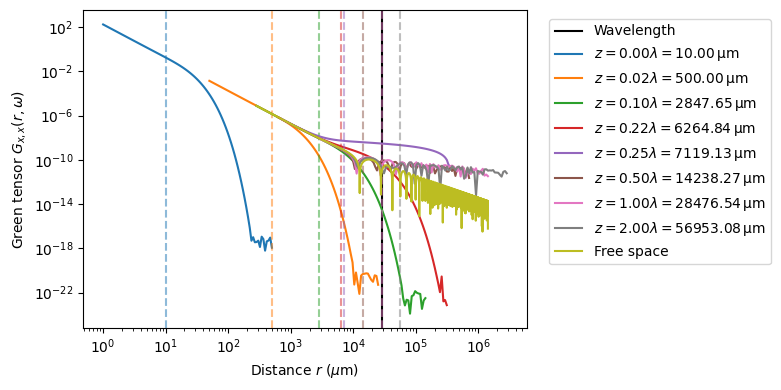

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.axvline(wavelength_mum, color="k", ls="-", label="Wavelength")

for i, (z, V) in enumerate(V_dict.items()):
    color = f"C{i}"
    label = rf"$z = {z / wavelength_mum:.2f} \lambda = {z:.2f} \, \mathrm{{\mu m}}$"
    if np.isinf(z):
        label = r"Free space"

    distance_list = distance_dict[z]
    ax.plot(
        distance_list,
        np.real(V),
        color=color,
        label=label,
    )

    ax.axvline(z, color=color, ls="dashed", alpha=0.5)


ax.set_ylabel(r"Green tensor $G_{x,x}(r, \omega)$")
ax.set_xlabel(r"Distance $r$ ($\mu$m)")

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(loc=(1.05, 0.2))
fig.tight_layout()

plt.show()

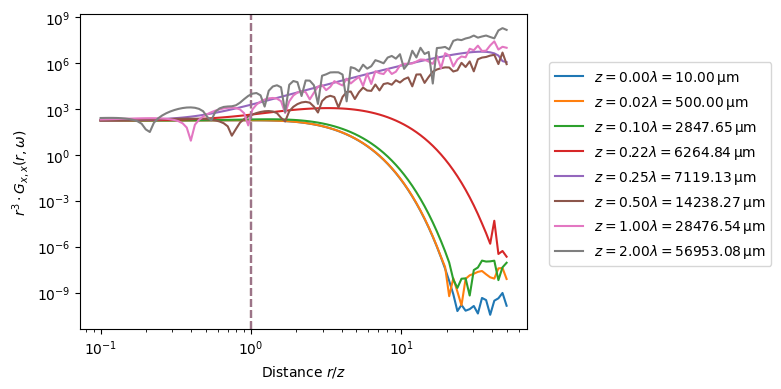

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))

for i, (z, V) in enumerate(V_dict.items()):
    color = f"C{i}"
    label = rf"$z = {z / wavelength_mum:.2f} \lambda = {z:.2f} \, \mathrm{{\mu m}}$"
    if np.isinf(z):
        continue

    distance_list = distance_dict[z]
    ax.plot(
        distance_list / z,
        np.real(V) * distance_list**3,
        color=color,
        label=label,
    )

    ax.axvline(z / z, color=color, ls="dashed", alpha=0.5)


ax.set_ylabel(r"$r^3 \cdot G_{x,x}(r, \omega)$")
ax.set_xlabel(r"Distance $r / z$")

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(loc=(1.05, 0.2))
fig.tight_layout()

plt.show()